# User Inputs

In [34]:
#==========
# General Setting
#==========

# set core path
path = '/Users/Mark/Documents/Github/Fantasy_Football/'

db_name = 'Model_Inputs.sqlite3'

# set to position to analyze: 'RB', 'WR', 'QB', or 'TE'
set_pos = 'WR'


#==========
# Data Filtering
#==========

# set year to analyze
set_year = 2018
earliest_year = 2002

# set required touches (or pass thrown) and games for consideration
req_games = 8
req_touch = 50


#==========
# Fantasy Point Values
#==========

# settings for fantasy points
pts = {}
pts['yd_pts'] = 0.1
pts['pass_yd_pts'] = 0.04
pts['td_pts'] = 7
pts['pass_td_pts'] = 5
pts['rec_pts'] = 0.5
pts['fmb_pts'] = -2.0
pts['int_pts'] = -2
pts['sack_pts'] = -1


#==========
# Model Settings
#==========

# VIF threshold to include a feature
vif_thresh = 2500

# number of hypersearch rounds for training ensemble
iter_rounds = 25

# number of time to repeat predictions when generation prior distributions
prior_repeats=5

# whether or not to plot bayes outputs
plot_importance = False

# Load Libraries

In [35]:
# core packages
import pandas as pd
import numpy as np
import os
import sqlite3

# jupyter specifications
pd.options.mode.chained_assignment = None
from IPython.core.interactiveshell import InteractiveShell
#InteractiveShell.ast_node_interactivity = "all"
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

# plotting functions
import matplotlib.pyplot as plt
import seaborn as sns

In [36]:
# change directory temporarily to helper scripts
os.chdir(path + 'Scripts/Analysis/Helper_Scripts')

# load custom plot functions
from my_plot import PrettyPlot
PrettyPlot(plt)

# load custom helper functions
from helper_functions import *;

# Merge and Clean Data Files

In [37]:
#==========
# Pull and clean compiled data
#==========

conn = sqlite3.connect(path + 'Data/' + db_name)
df = pd.read_sql_query('SELECT * FROM ' + set_pos + '_2018', con=conn)

# split old and new to filter past years based on touches.
# leave all new players in to ensure everyone gets a prediction
old = df[(df[pos[set_pos]['touch_filter']] > req_touch) & (df.games > req_games) & (df.year < set_year-1)].reset_index(drop=True)
this_year = df[df.year==set_year-1]

# merge old and new back together after filtering
df = pd.concat([old, this_year], axis=0)

# create dataframes to store results
df_train_results = pd.DataFrame([old.player, old.year]).T
df_test_results = pd.DataFrame([this_year.player]).T

# calculate FP
df, pts_list = calculate_fp(df, pts, pos=set_pos)

Running Models for rec_yd_per_game
----------------------------------
Corr removed  104 / 150  features
Running VIF Feature Reduction
Dropped  7 / 44  columns
Training Ensemble Model
2018-12-27 08:52:24
Completed 10/25 iterations
2018-12-27 08:52:39
Completed 20/25 iterations
     lgbm    xgb  lasso  ridge   rmse    mae  r2_pred  c_pred  r2_adp  c_adp
0   0.247  0.247  0.254  0.252  15.53  12.09    0.319   0.565   0.347  0.589
18  0.248  0.247  0.254  0.251  15.61  12.17    0.314   0.560   0.347  0.589
6   0.248  0.248  0.253  0.252  15.65  12.19    0.310   0.557   0.347  0.589
1   0.247  0.246  0.255  0.252  15.66  12.19    0.305   0.553   0.347  0.589
17  0.248  0.245  0.255  0.253  15.66  12.22    0.303   0.550   0.347  0.589
11  0.248  0.246  0.254  0.252  15.67  12.22    0.307   0.554   0.347  0.589
14  0.246  0.248  0.254  0.252  15.68  12.23    0.311   0.558   0.347  0.589
16  0.247  0.248  0.254  0.251  15.68  12.22    0.308   0.555   0.347  0.589
23  0.248  0.247  0.253  0.251

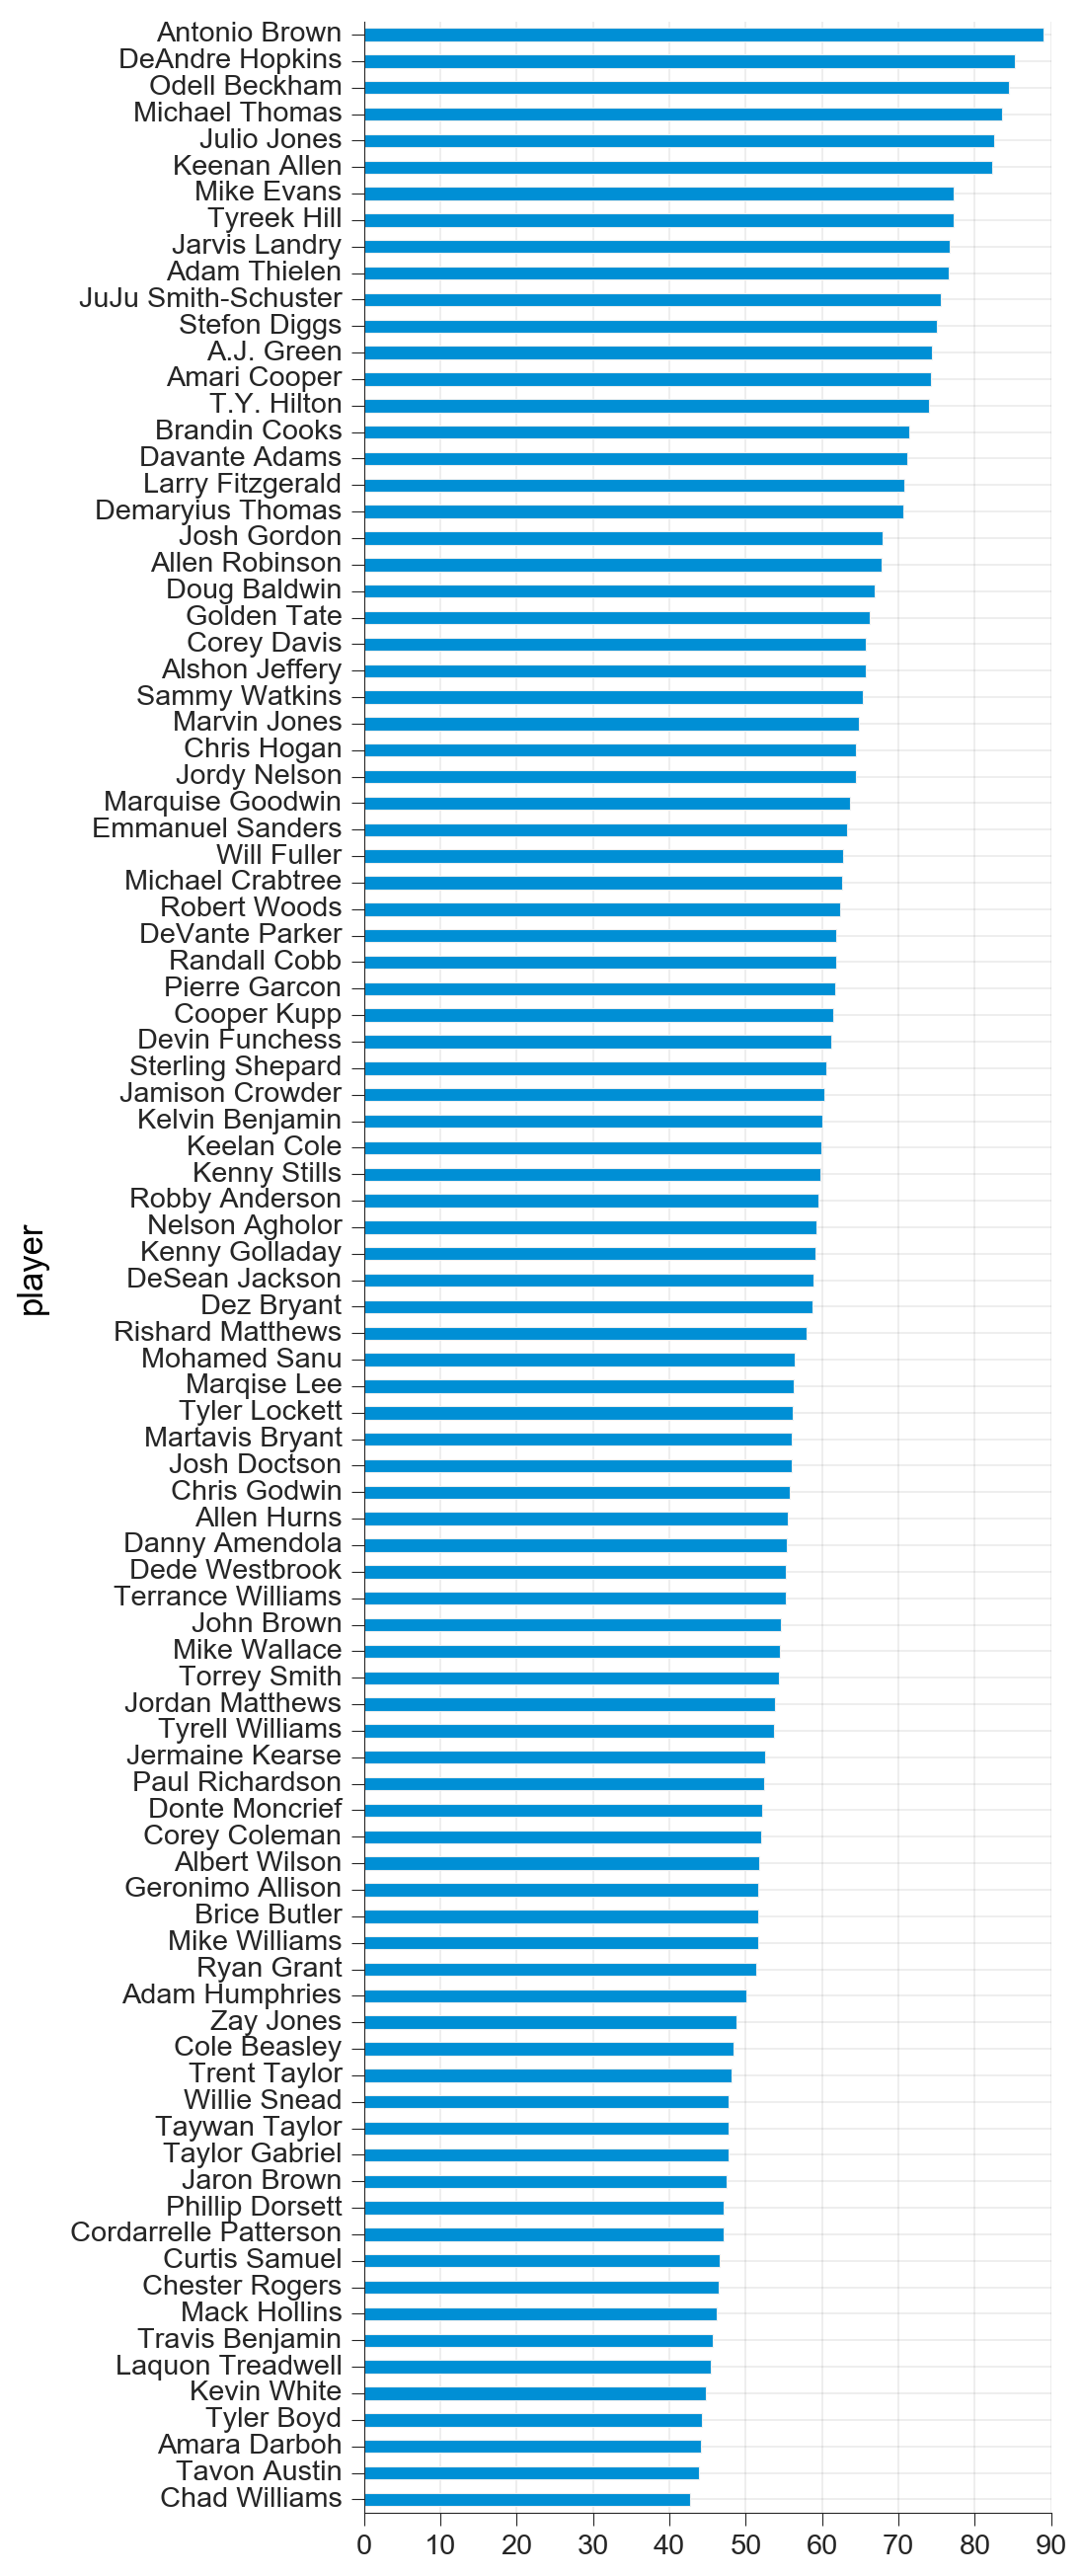

Running Models for rec_per_game
----------------------------------
Corr removed  105 / 150  features
Running VIF Feature Reduction
Dropped  7 / 43  columns
Training Ensemble Model
2018-12-27 08:53:04
Completed 10/25 iterations
2018-12-27 08:53:17
Completed 20/25 iterations
     lgbm    xgb  lasso  ridge  rmse   mae  r2_pred  c_pred  r2_adp  c_adp
0   0.260  0.260  0.219  0.262  1.07  0.84    0.364   0.603   0.315  0.561
13  0.254  0.252  0.236  0.257  1.07  0.84    0.359   0.599   0.315  0.561
1   0.259  0.260  0.219  0.262  1.08  0.85    0.367   0.606   0.315  0.561
23  0.260  0.259  0.220  0.261  1.08  0.84    0.363   0.603   0.315  0.561
14  0.259  0.261  0.219  0.262  1.08  0.85    0.361   0.600   0.315  0.561
2   0.260  0.259  0.219  0.262  1.08  0.85    0.360   0.600   0.315  0.561
20  0.259  0.258  0.221  0.263  1.08  0.85    0.360   0.600   0.315  0.561
16  0.260  0.260  0.219  0.261  1.08  0.84    0.359   0.599   0.315  0.561
8   0.259  0.259  0.220  0.263  1.08  0.84    0.358

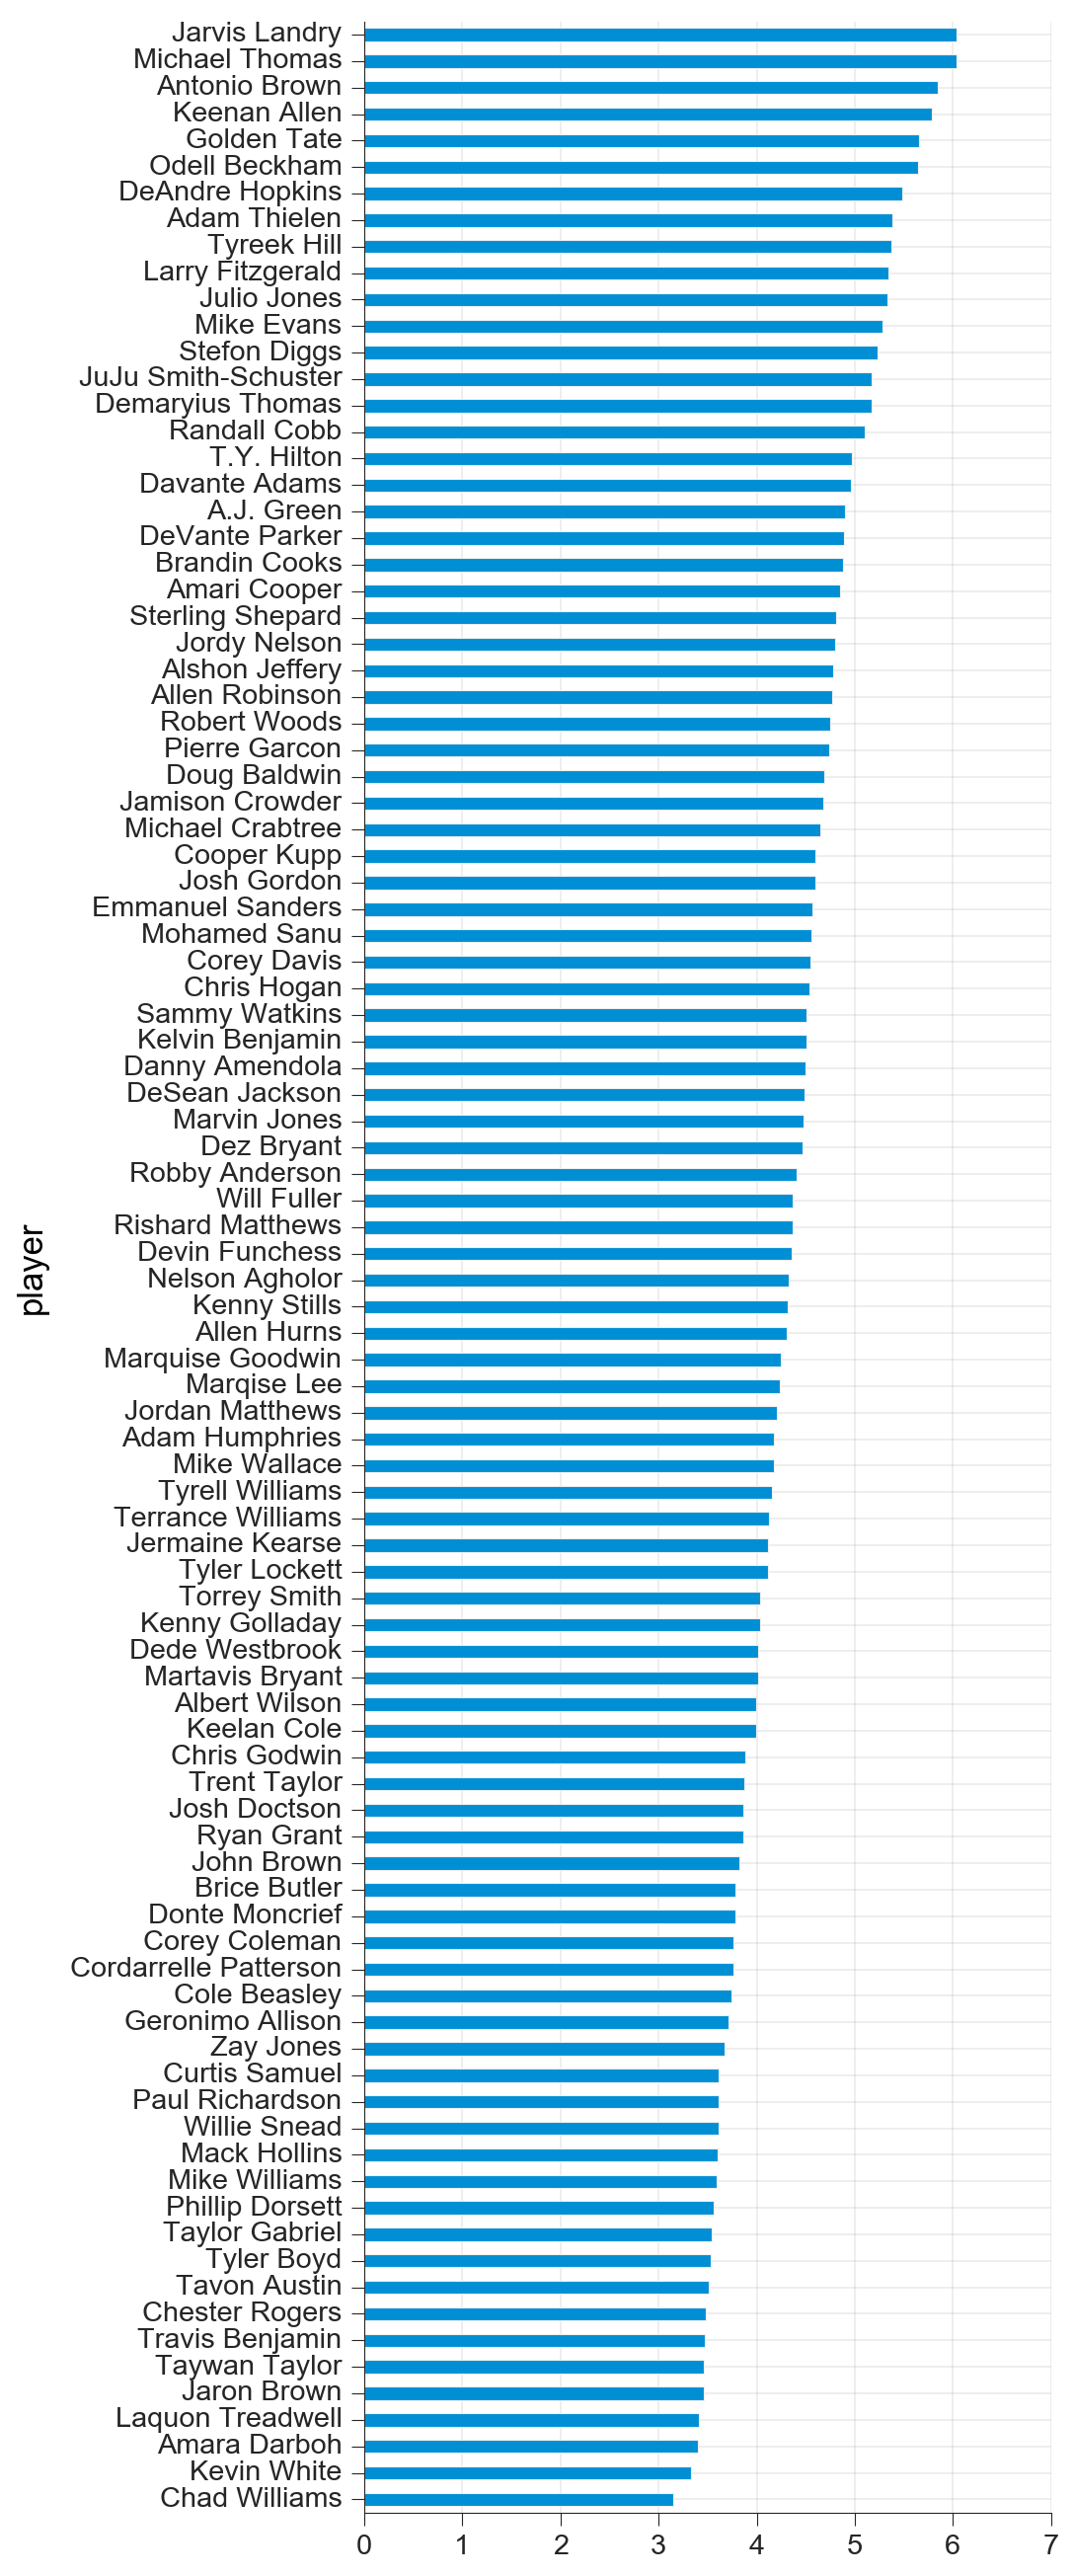

Running Models for td_per_game
----------------------------------
Corr removed  114 / 150  features
Running VIF Feature Reduction
Dropped  6 / 34  columns
Training Ensemble Model
2018-12-27 08:53:41
Completed 10/25 iterations
2018-12-27 08:53:52
Completed 20/25 iterations
     lgbm    xgb  lasso  ridge  rmse   mae  r2_pred  c_pred  r2_adp  c_adp
0   0.249  0.251  0.243  0.257  0.19  0.15    0.141   0.376   0.161  0.401
6   0.251  0.252  0.241  0.256  0.19  0.15    0.133   0.365   0.161  0.401
3   0.250  0.248  0.244  0.258  0.19  0.15    0.129   0.359   0.161  0.401
7   0.250  0.252  0.242  0.255  0.19  0.15    0.126   0.355   0.161  0.401
23  0.252  0.252  0.241  0.256  0.19  0.15    0.126   0.354   0.161  0.401
15  0.250  0.252  0.242  0.256  0.19  0.15    0.125   0.353   0.161  0.401
20  0.247  0.250  0.245  0.258  0.19  0.15    0.125   0.353   0.161  0.401
24  0.249  0.250  0.244  0.257  0.19  0.15    0.125   0.354   0.161  0.401
8   0.250  0.249  0.244  0.257  0.19  0.15    0.122 

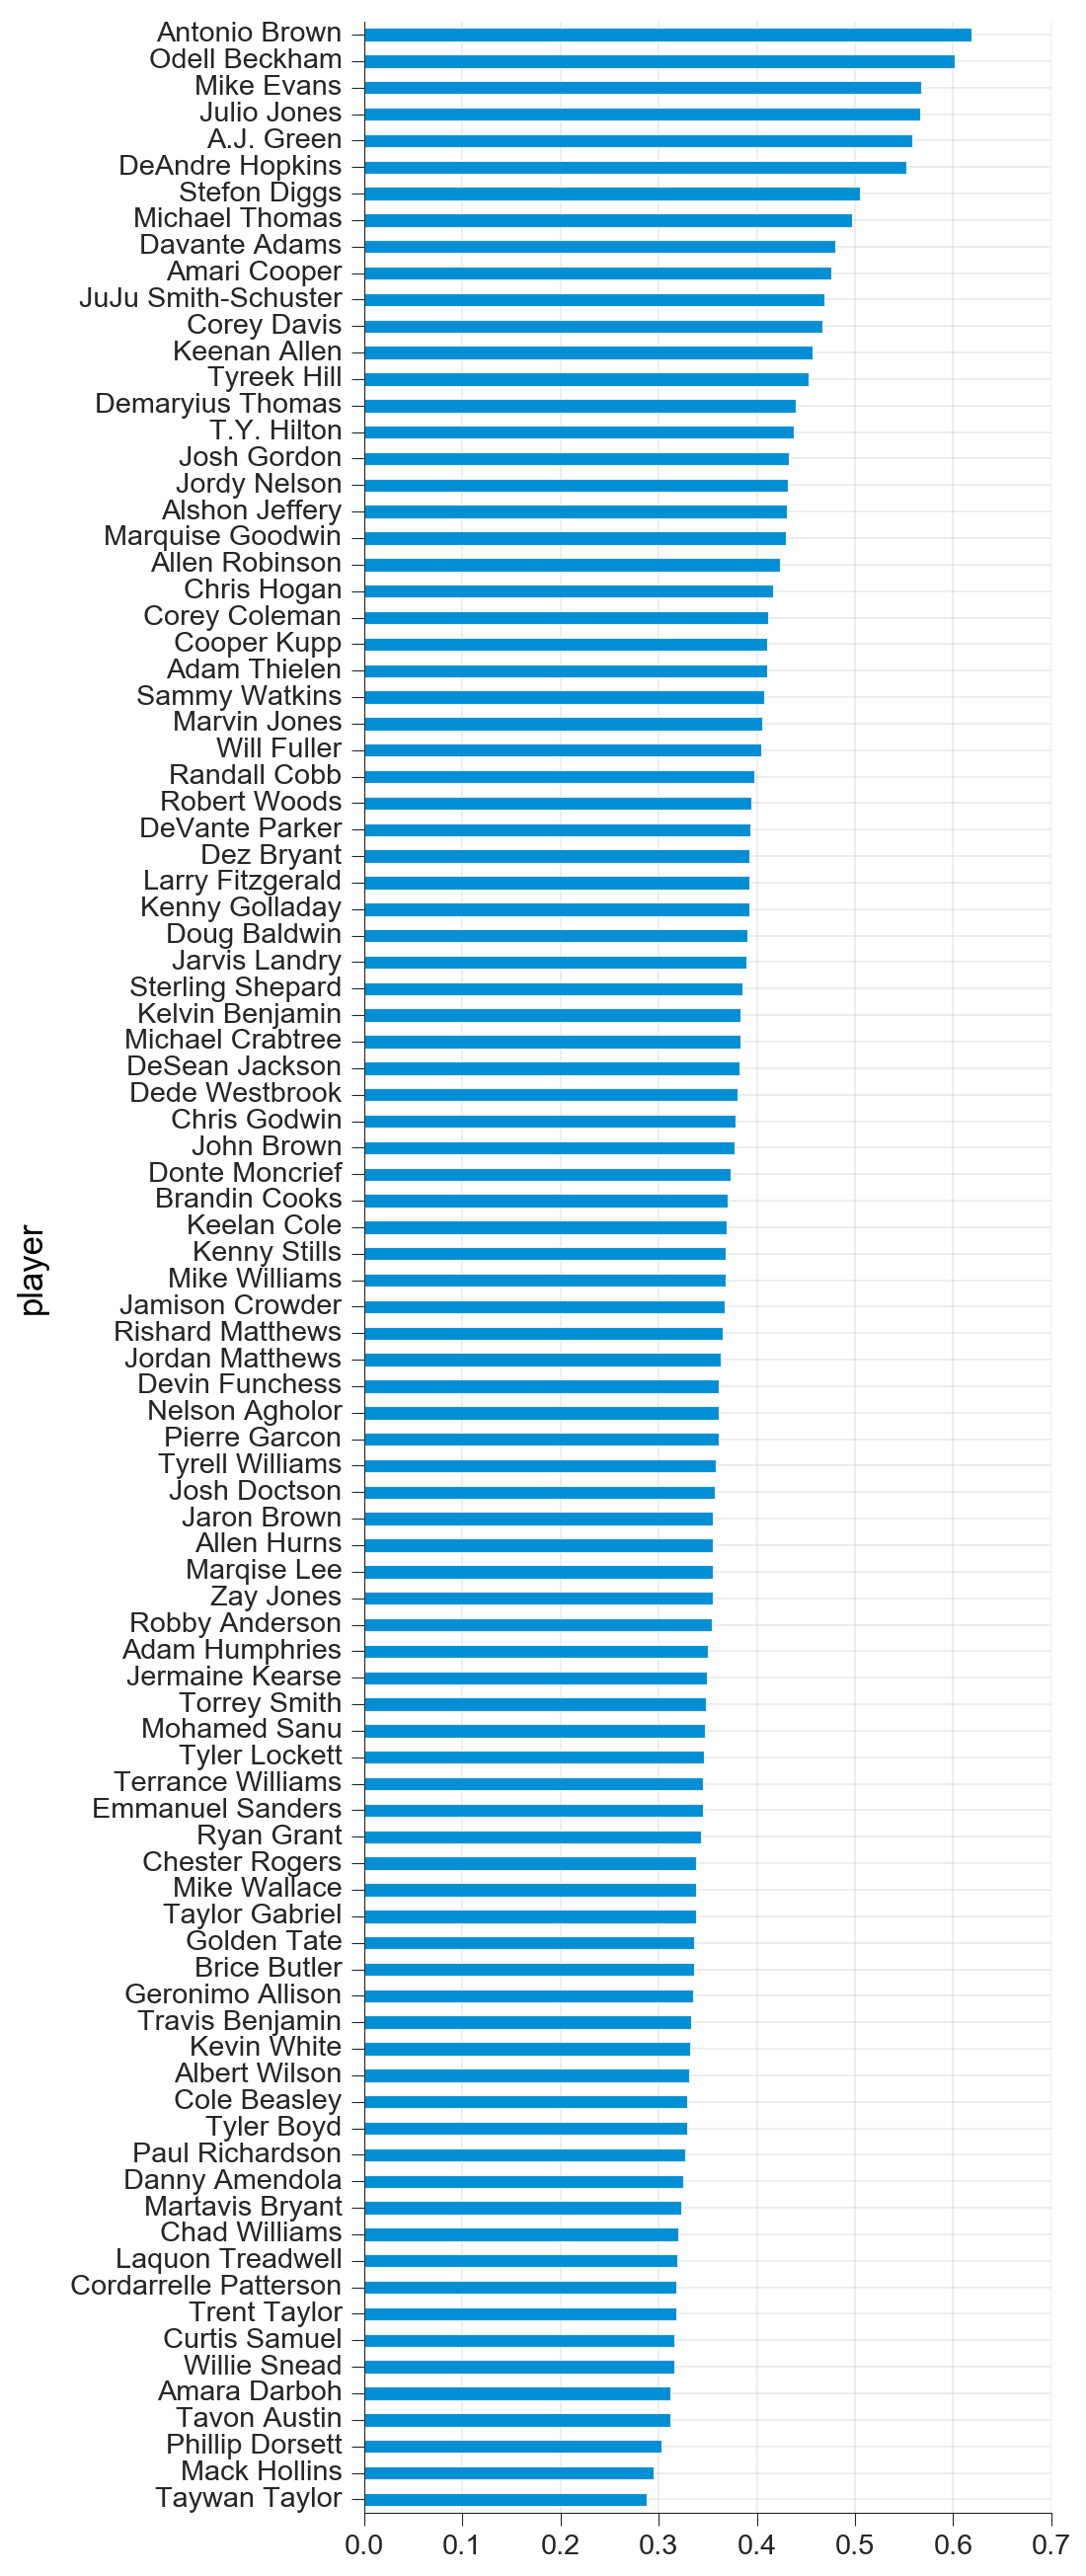

In [38]:
#==========
# Loop to create statistical predictions
#==========

output = {}

for metric in pos[set_pos]['metrics']:
    
    df_train_chunks = pd.DataFrame()
    df_test_chunks = pd.DataFrame()

    print('Running Models for ' + metric)
    print('----------------------------------')

    #--------
    # Create train and predict dataframes
    #--------
    df_train_full, df_predict_full = features_target(df,
                                                     earliest_year, set_year-1,
                                                     pos[set_pos]['med_features'],
                                                     pos[set_pos]['sum_features'],
                                                     pos[set_pos]['max_features'],
                                                     pos[set_pos]['age_features'],
                                                     target_feature=metric)
    
    df_train_full = df_train_full.dropna(subset=['y_act']).reset_index(drop=True)
    df_train_full = df_train_full.fillna(df_train_full.mean())
    df_predict_full = df_predict_full.dropna().reset_index(drop=True)
    
    for i in [1]:
        
        if i == 1:
            df_train = df_train_full
            df_predict = df_predict_full
            #df_train = df_train_full[df_train_full.avg_pick < 4.6].reset_index(drop=True)
            #df_predict = df_predict_full[df_predict_full.avg_pick < 4.6].reset_index(drop=True)
        
        #if i == 2:
        #    df_train = df_train_full[(df_train_full.avg_pick >= 3.6) & (df_train_full.avg_pick < 4.6)].reset_index(drop=True)
        #    df_predict = df_predict_full[(df_predict_full.avg_pick >= 3.6) & (df_predict_full.avg_pick < 4.6)].reset_index(drop=True)
        
        #if i == 2:
        #    df_train = df_train_full[df_train_full.avg_pick >= 4.6].reset_index(drop=True)
        #    df_predict = df_predict_full[df_predict_full.avg_pick >= 4.6].reset_index(drop=True)
            
        #--------
        # Remove low correlation features and high VIF features
        #--------

        # remove low correlation features
        df_train, df_predict = corr_removal(df_train, df_predict, corr_cutoff=0.2)

        # select only features with low vif for modeling
        transformer = ReduceVIF(thresh=vif_thresh, scale=True, print_progress=False)
        df_train_ = transformer.fit_transform(df_train.drop(['y_act', 'player'], axis=1), df_train.y_act)

        # extract best columns and filter down df_predict
        best_cols = list(df_train_.columns)
        best_cols.extend(['player', 'year', 'avg_pick'])
        df_predict = df_predict[best_cols]
        df_predict = df_predict.loc[:,~df_predict.columns.duplicated()]

        # add target and filter down df_train
        best_cols.extend(['y_act', 'year', 'avg_pick'])
        df_train = df_train[best_cols]
        df_train = df_train.loc[:,~df_train.columns.duplicated()]

        #--------
        # Run ensemble model with parameter optimization
        #--------

        # generate a master dictionary of parameters (must match the)
        param_list = [lgbm_params, xgb_params, lasso_params, ridge_params]
        est_names = ['lgbm', 'xgb', 'lasso', 'ridge']

        params = {}
        for i, param in enumerate(param_list):
            params[est_names[i]] = param

        print('Training Ensemble Model')
        param_results, summary, df_train_results_, errors = validation(est_names, params, df_train, iterations=iter_rounds, random_state=1234)

        #--------
        # Print best results
        #--------

        # print a summary of error metrics, weightings of various models, and a comparison to 
        # using straight adp as as a prediction for next year's stats
        print(summary.head(10))

        # pull out the best result for the random hyperparameter search of models
        best_result = summary.index[0]

        # pass the best hyperparameters into the generation_prediction function, which
        # will return the test results for the current year and the trained best models
        df_test_results_, models = generate_predictions(best_result, param_results, summary, df_train, df_predict)

        #--------
        # Aggregate all results through merging
        #--------

        # add models to output dictionary
        output[metric] = {}
        output[metric]['models'] = models

        # add params to output dictionary
        output[metric]['params'] = param_results

        # add columns to output dictionary
        cols = list(df_train.columns)
        cols.remove('y_act')
        cols.remove('player')
        output[metric]['cols'] = cols
        
        # concat the chunk for each metric together into one dataframe
        df_train_results_ = df_train_results_.rename(columns={'pred': 'pred_' + metric})
        df_train_results_ = df_train_results_[['player', 'year', 'pred_' + metric]]
        df_train_chunks = pd.concat([df_train_chunks, df_train_results_], axis=0).reset_index(drop=True)
        
        # concat the chunk for each metric together into one dataframe
        df_test_results_ = df_test_results_.rename(columns={'pred': 'pred_' + metric})
        df_test_results_ = df_test_results_[['player', 'pred_' + metric]]
        df_test_chunks = pd.concat([df_test_chunks, df_test_results_], axis=0).reset_index(drop=True)
    
    # merge the train results for the given metric with all other metric outputs
    df_train_results = pd.merge(df_train_results, df_train_chunks, 
                                how='inner', left_on=['player', 'year'], right_on=['player', 'year'])
    # merge the test results for the given metric with all other metric outputs
    df_test_results = pd.merge(df_test_results, df_test_chunks, 
                               how='inner', left_on='player', right_on='player')

# after loop, set the df_train to have the y_act as fp_per_game
df_train, df_predict = features_target(df, earliest_year, set_year-1, 
                                           pos[set_pos]['med_features'], 
                                           pos[set_pos]['sum_features'],
                                           pos[set_pos]['max_features'], 
                                           pos[set_pos]['age_features'],
                                           target_feature='fp_per_game')

In [ ]:
#==========
# If desired, plot feature importances for a given metric / model
#==========

if plot_importance == True:
    
    metric = 'rush_yd_per_game'
    i = 0
    try:
        plot_results(output[metric]['models'][i].feature_importances_, col_names=output[metric]['cols']);
    except:
        plot_results(output[metric]['models'][i].coef_, col_names=output[metric]['cols']);

In [ ]:
#==========
# Calculate fantasy points based on predictions and point values
#==========

df_train_results, df_test_results = format_results(df_train_results, df_test_results, 
                                                   df_train, df_predict, pts_list)

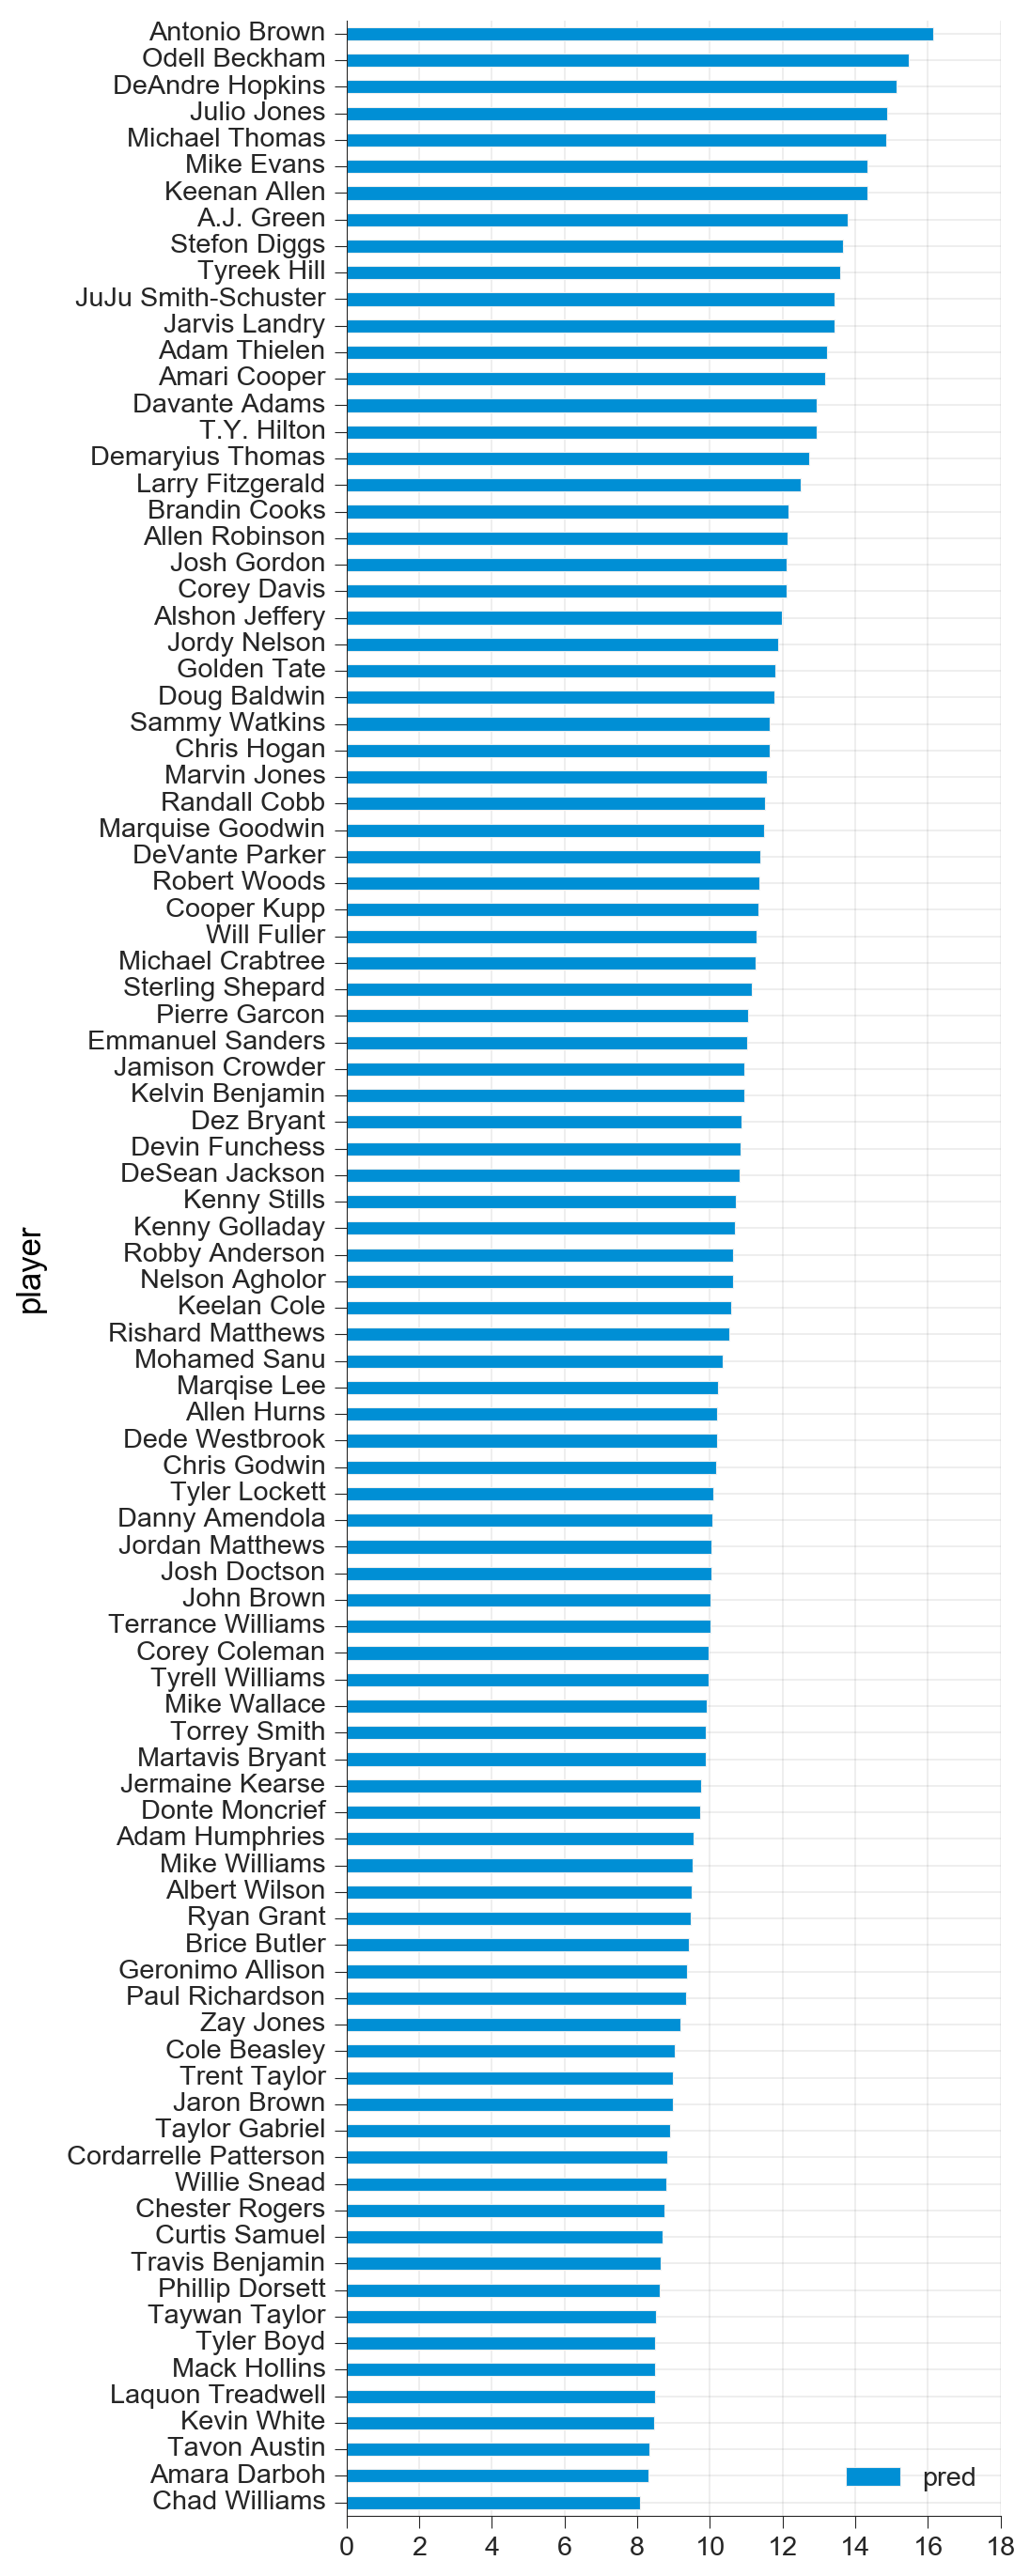

In [46]:
#==========
# Plot Predictions for Each Player
#==========

df_test_results.sort_values('pred').plot.barh(x='player', y='pred', figsize=(5,20));

# Clustering Players into Tiers

In [47]:
#==========
# Group Players into Clusters Using Decision Tree
#==========

# initialize cluster with train and test results
cluster = clustering(df_train_results, df_test_results)

# fit decision tree and apply nodes to players
cluster.fit_and_predict_tree()

# add linear regression of predicted vs actual for cluster predictions
c_train, c_test = cluster.add_fit_metrics()

Best RMSE:  2.942
Cluster List:  [12, 11, 7, 6, 4, 3, 9]


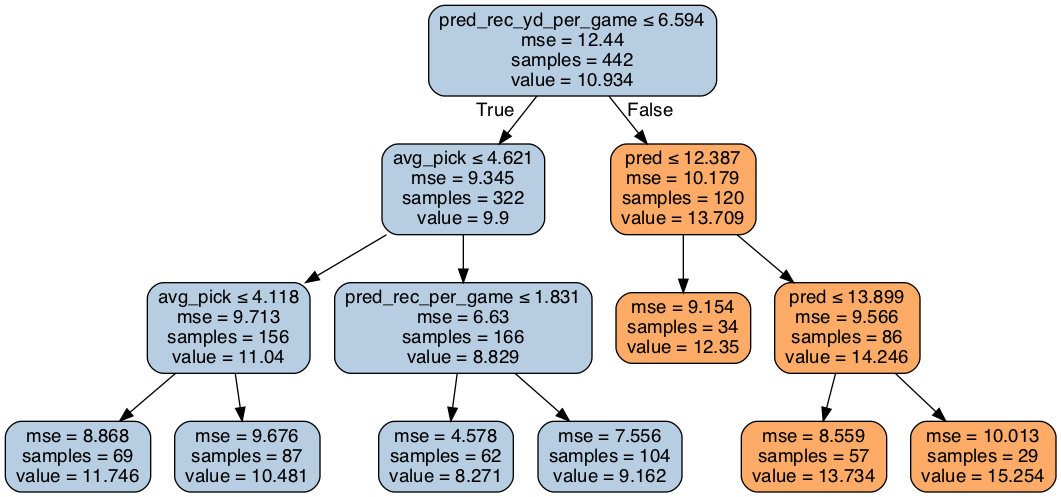

In [48]:
#==========
# Create Graph of Decision Tree Logic
#==========

cluster.tree_plot()

Fantasy PPG for Various Percentiles
-----------------------------------
5th percentile:  9.56
25th percentile: 11.79
50th percentile: 13.61
75th percentile: 16.02
95th percentile: 18.35

Pred to Actual Correlation
0.029


,player,pred,cluster_pred
26,A.J. Green,13.791608,14.730561
12,Stefon Diggs,13.660231,14.550558
16,Tyreek Hill,13.573682,14.431977
1,JuJu Smith-Schuster,13.422650,14.225046
93,Jarvis Landry,13.416398,14.216480
11,Adam Thielen,13.222480,13.950790
72,Amari Cooper,13.175499,13.886420
51,Davante Adams,12.947806,13.574454
42,T.Y. Hilton,12.942785,13.567574
9,Demaryius Thomas,12.733111,13.280297


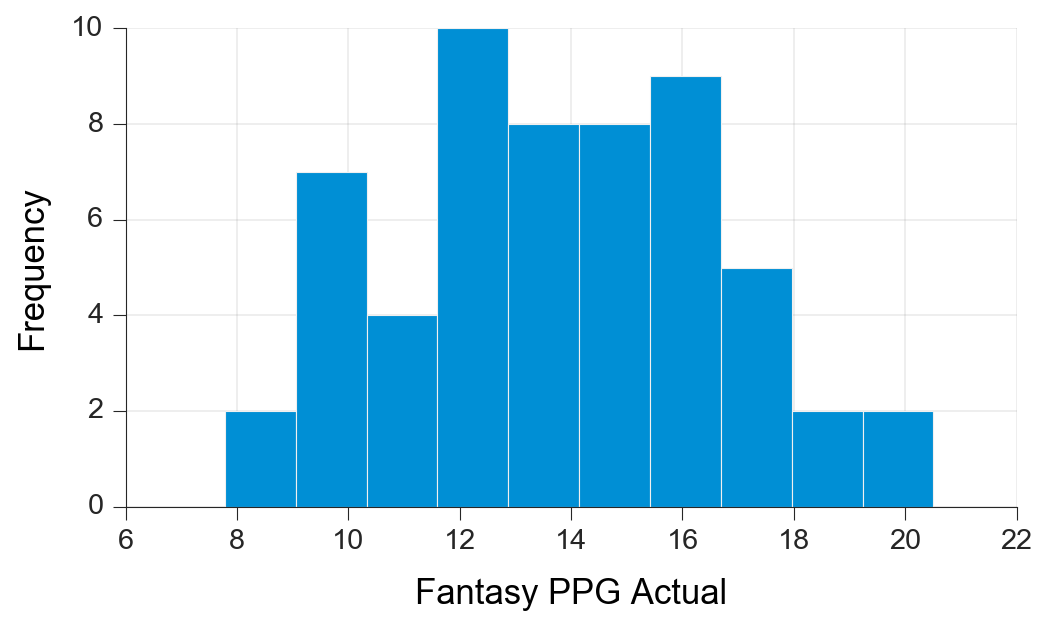

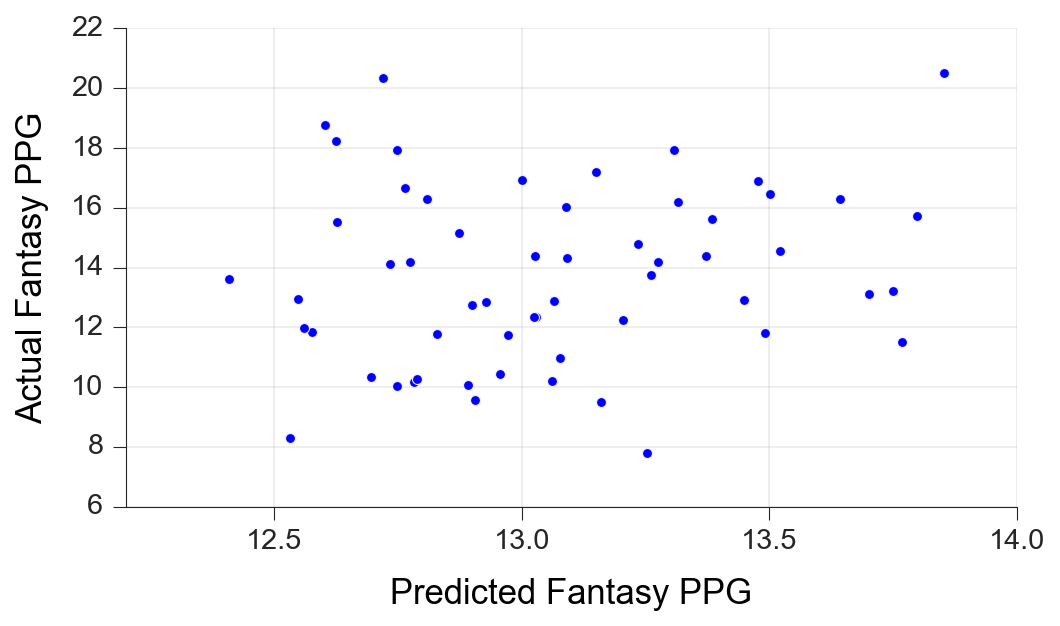

In [50]:
#==========
# Show the Results for Each Cluster
#==========

cluster.show_results(j=11)

###### ==========
# Create the Distributions and Plot Prior / Posterior Results
#==========

distributions = cluster.create_distributions(prior_repeats=5)

In [ ]:
distributions.to_csv(path + 'Results/' + str(set_year) + '/' + set_pos + '_Distributions.csv', index=False)